# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
import numpy.typing as npt
from collections import deque

from utils import normalize_image, plot_enviroment, plotting_results

# task 1: configuration space

**robot**: "rod" object with configuration [x,y,theta]
- x,y: image coordinates, int
- theta: orientation, descretized

**data_ps1.npz**: 
- environment map 
  ```python
  ['environment'](np.ndarray([100,100]))
  ```
  | 0          | 1        |
  | ---------- | -------- |
  | free space | obstacle |
  
- robot/agent 
    ```python
    ['rod'](np.ndarray([11,11,4]))
    ```
  4 different discretization orientations:
    0, 45, 90, 135 degrees positions
  | 0          | 1        |
  | ---------- | -------- |
  | free space | rod      |


In [2]:
# load data
data = np.load('data_ps1.npz')
rod = data['rod']
environment = data['environment']
assert rod.shape == (11, 11, 4)
assert environment.shape == (100, 100)


### A (10 pts) Visualize from the given data the workspace and the different rod configurations for each discretized orientation. Comment on the given discretized values for orientation.

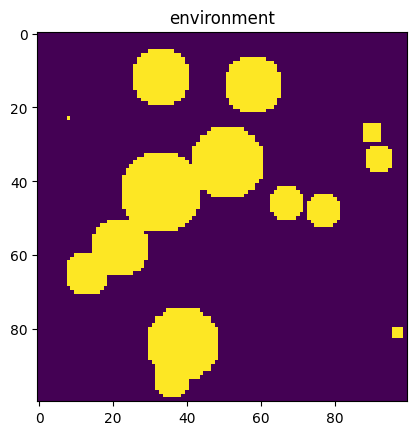

In [3]:
plt.imshow(environment)
plt.title('environment')
plt.show()


In [4]:
def plot_for_4_orientations(imgs, suptitle, N_orientations=4, figsize=(8, 8)):
    fig, axs = plt.subplots(2, N_orientations//2,
                            figsize=figsize, tight_layout=True)
    for orientation in range(N_orientations):
        i = orientation
        axs[int(i//2), int(i % 2)].imshow(imgs[:, :, orientation])
        axs[int(i//2), int(i % 2)
            ].set_title(f'orientation {orientation}: {orientation*45} degrees')
    fig.suptitle(f'{suptitle}')
    plt.show()


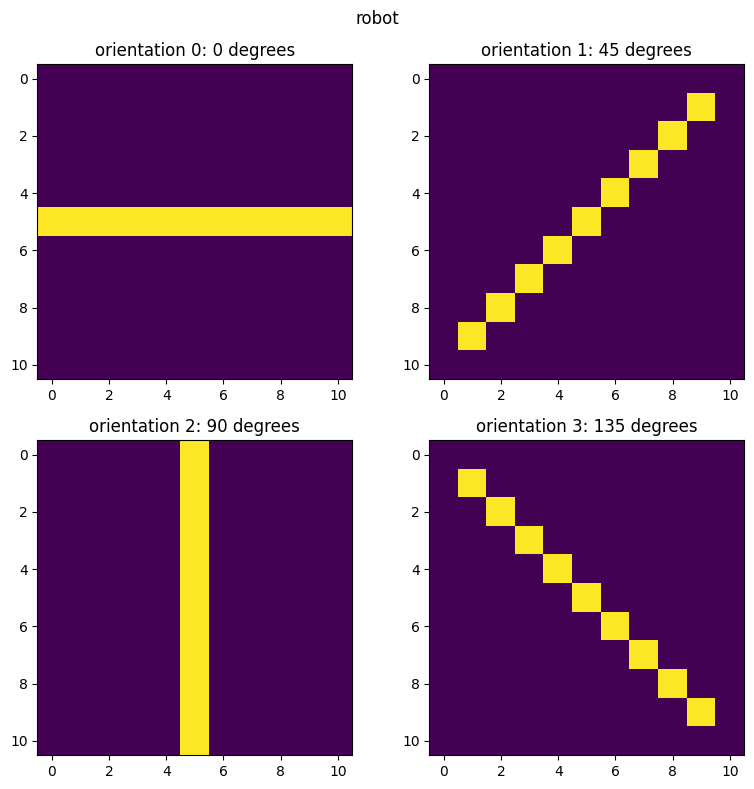

In [5]:
plot_for_4_orientations(rod, 'robot')


### B (10 pts) Visualize the *environment* together with the object. For this, you may want to use the function plot_joint_environment from *utils.py* and select any valid configuration value for the rod

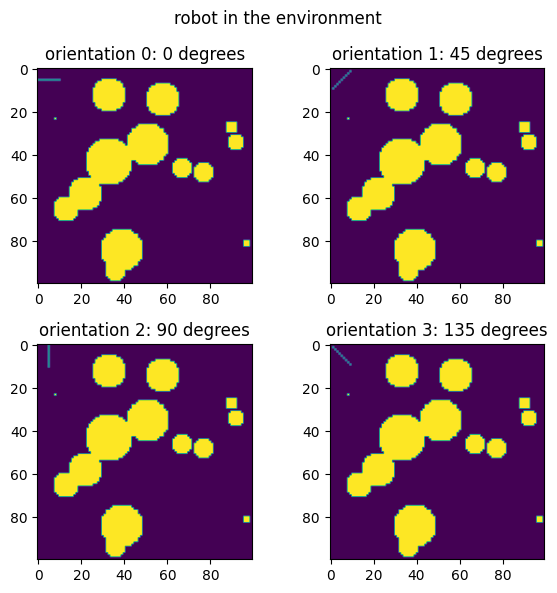

In [6]:
merged_envs = [plot_enviroment(environment, rod, (5, 5, orient))
               for orient in range(4)]
merged_envs = np.dstack(merged_envs)
plot_for_4_orientations(
    merged_envs, 'robot in the environment', figsize=(6, 6))


### C (10 pts) Create the C-space for the 2D environment map. For this, plot all the images corresponding to each of the orientations by using collision checking.

**hint**: you might want to look at the library `scipy.signal` and use function `signal.convolve2d(env_map, kernel, boundary=’symm’, mode=’same’)` to check for collisions.

**hint**: you may want to use `normalize_image(img)` from *utils.py* to normalize created space to ${0,1}$, since after convolutions, values are not exactly $0$ and $1$ (this will be useful for task 2)

padded for adding borders.
Important! padding shifts indexes!

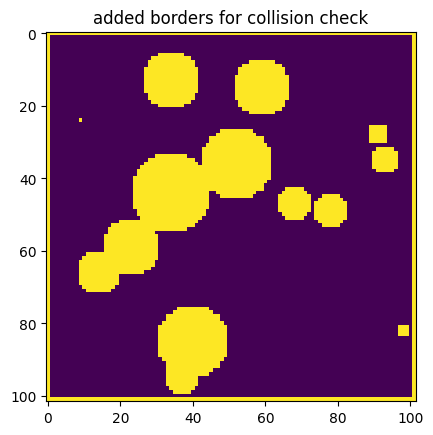

In [7]:
environment_edged = np.pad(environment,pad_width=1,constant_values=1)
plt.imshow(environment_edged)
plt.title("added borders for collision check")
plt.show()

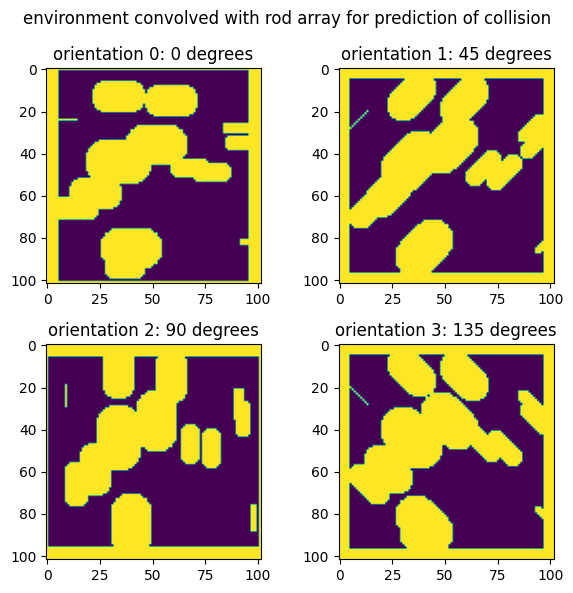

In [8]:
check_collision_envs = []
for orient in range(rod.shape[-1]):
    kernel = rod[:, :, orient]
    convolved_env = convolve2d(
        environment_edged, kernel, mode='same', boundary='symm')
    check_collision_envs.append(normalize_image(convolved_env))
check_collision_envs = np.dstack(check_collision_envs)

plot_for_4_orientations(check_collision_envs,
                        'environment convolved with rod array for prediction of collision',
                        figsize=(6, 6))


### D (10 pts) Comment on the obtained C-space with the previous method. What is the size of the C-space?

In [9]:
# x and y are increased due to padding
check_collision_envs.shape

(102, 102, 4)

If the center of robot is in convolved environment then collision happened 

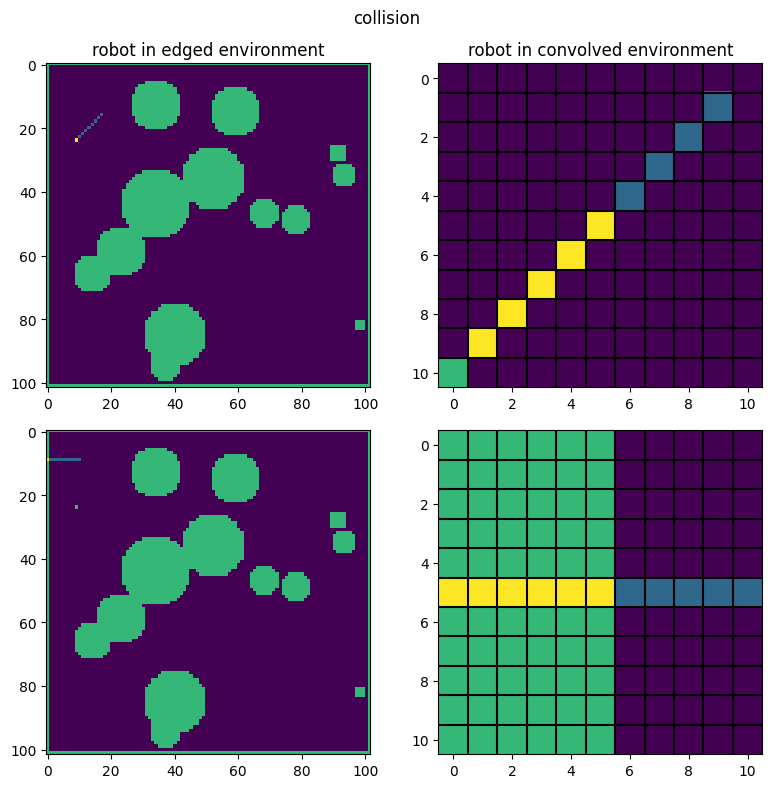

In [10]:
fig, axs = plt.subplots(2,2,tight_layout=True, figsize=(8,8))
axs[0,0].imshow(plot_enviroment(environment_edged, rod, (19+1, 12+1, 1), cut=False))
axs[0,0].set_title("robot in edged environment")

axs[0,1].imshow(plot_enviroment(check_collision_envs[:, :, 1], rod, (19+1, 12+1, 1), cut=True))
axs[0,1].vlines(np.arange(0.5,10.5,1),-0.5,10.5,color='k')
axs[0,1].hlines(np.arange(0.5,10.5,1),-0.5,10.5,color='k')
axs[0,1].set_title("robot in convolved environment")

axs[1,0].imshow(plot_enviroment(environment_edged, rod, (8+1, 4+1, 0), cut=False))

axs[1,1].imshow(plot_enviroment(check_collision_envs[:, :, 0], rod, (8+1, 4+1, 0), cut=True))
axs[1,1].vlines(np.arange(0.5,10.5,1),-0.5,10.5,color='k')
axs[1,1].hlines(np.arange(0.5,10.5,1),-0.5,10.5,color='k')

fig.suptitle('collision')
plt.show()

# Task 2: A star Algorithm (60 points)

For this task, you will implement a graph search algorithm. The actions allowed in this problem are __moving up, down, left, right, rotate right, rotate left__. In total 6 actions, each of them has an assigned a __cost of 1__

### **A (40 pts)** You need to implement the A star algorithm and plan in the generated discrete C-space from the previous task. 
The starting configuration of the agent is (6,6,2) and the goal configuration is (55,55,0). On this first iteration, **use an heuristic function h(q,qG) = 0, which is equivalent to the Dijkstra algorithm.** Save the result of calculated plan in rod_solve.mp4 using plotting_result(environment,rod,plan) from utils.py, where plan is list of rod states from start to goal. 

**hint:** Track the number of visited states to avoid/debug potential issues with internal loops

In [11]:
start = (6,6,2)
goal = (55,55,0)

actions = [(-1, 0, 0),  #  'left'
           (1, 0, 0),   # 'right' 
           (0, -1, 0),  # 'up'  
           (0, 1, 0),   # 'down'  
           (0, 0, -1),  # 'rot_right'   
           (0, 0, 1)]   # 'rot_left'

In [12]:
def move(init_pos: npt.ArrayLike, action: npt.ArrayLike) -> tuple:
  init_pos = np.array(init_pos)
  action = np.array(action)
  assert len(init_pos) == 3

  new_pos = init_pos + action
  new_pos[-1] %= 4
  return tuple(new_pos)


def check_collision(location: tuple[int],
                    check_collision_envs: np.ndarray=check_collision_envs):
  location = np.array(location)
  location += [1,1,0] # due to padding for borders
  # print(location)
  # print(check_collision_envs[location[0],location[1],location[2]])
  if(check_collision_envs[location[0],location[1],location[2]]):
    return True
  return False


def table_to_plan(parent_table: set)-> list:
  plan = [goal]
  location = parent_table[goal]
  plan.append(location)
  while location != start:
    location = parent_table[location]
    plan.append(location)
  return plan[::-1]


def update_costs(x, parent_table: set, children: set, costs: np.ndarray)-> None:
  for child in children[x]:
    costs[child] = costs[x]+1
    update_costs(child, parent_table, children, costs)
  

def h_l1(x,y, goal=goal):
  return int(np.abs(x-goal[0])+np.abs(y-goal[1]))
def h_l1_(x,y,z, goal=goal):
  return int(np.abs(x-goal[0])+np.abs(y-goal[1])+np.abs(z-goal[2])%3)

In [13]:
def Astar(alg = 'dijkstra', start=start, goal=goal):
    Q = deque()
    costs = np.full((100,100,4),10**8, dtype=int)
    is_vizited = np.zeros_like(costs,dtype=bool)
    if alg == 'A*':
        heuristics = np.empty_like(costs)
        for i in range(100):
            for j in range(100):
                heuristics[i,j] = h_l1(i,j)
    elif alg == 'A*_':
        heuristics = np.empty_like(costs)
        for i in range(100):
            for j in range(100):
                for k in range(4):
                    heuristics[i,j] = h_l1_(i,j,k)
    costs[start] = 0
    parent_table = {}
    
    Q.insert(0, start)
    count = 1
    Q_len = [len(Q)]
    
    while len(Q) != 0:

        x_min = Q[0]
        cost_min = costs[x_min]
        if alg=='dijkstra':
            for x in Q:
                if costs[x] < cost_min:
                    x_min = x
                    cost_min = costs[x_min]
        elif alg in ['A*','A*_']:
            h_min = heuristics[x_min]
            for x in Q:                    
                if costs[x]+heuristics[x] < cost_min + h_min:
                    x_min = x
                    cost_min = costs[x_min]
                    h_min = heuristics[x_min]
        
        x = x_min    
        Q.remove(x)

        count +=1
        if x == goal:
            return True, table_to_plan(parent_table), count, costs

        for u in actions:
            x_new = move(x, u)
            if check_collision(x_new):
                continue

            if not is_vizited[x_new]:
                is_vizited[x_new] = 1
                parent_table[x_new] = x
                
                C = costs[x_new] = costs[x] + 1
                if alg == 'dijkstra':
                    h = 0
                elif alg in ['A*','A*_'] :
                    h = heuristics[x_new] #= h_l1(x_new,goal)

                Q.insert(C+h, x_new)
                Q_len.append(len(Q))
            else:
                if (costs[x]+1 < costs[x_new]):
                    costs[x_new] = costs[x]+1
                    parent_table[x_new] = x
                                            
    return False, table_to_plan(parent_table), count, costs

In [14]:
success, plan_d, count_d, costs_d = Astar(alg = 'dijkstra')
print(f'reached goal in {len(plan_d)} number of steps after {count_d} cycles')

reached goal in 117 number of steps after 13628 cycles


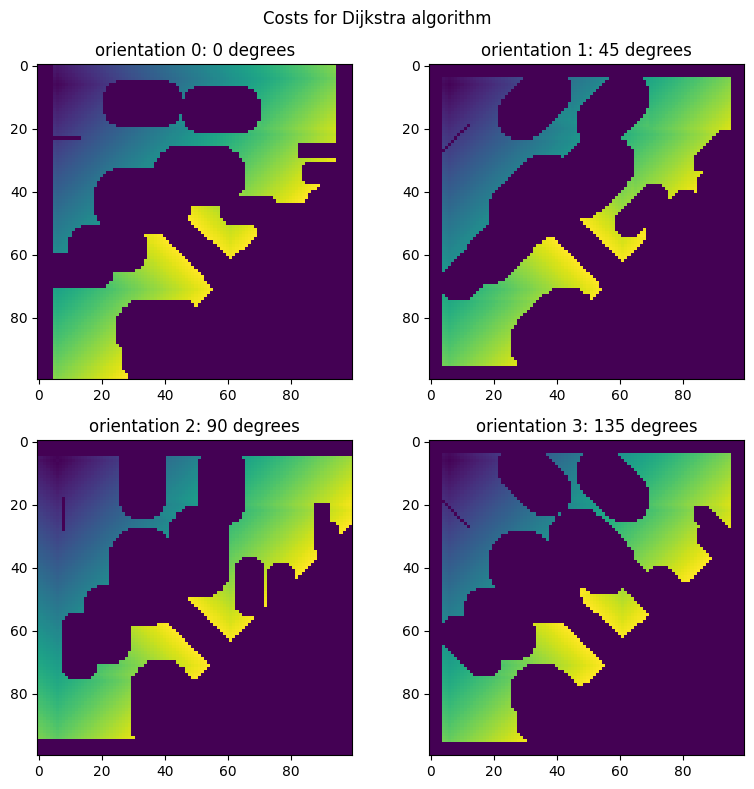

In [15]:
imgs = np.where(costs_d == 10**8, 0, costs_d) # change values for obstacles so they won't affect coloring of the images
plot_for_4_orientations(imgs, suptitle='Costs for Dijkstra algorithm')

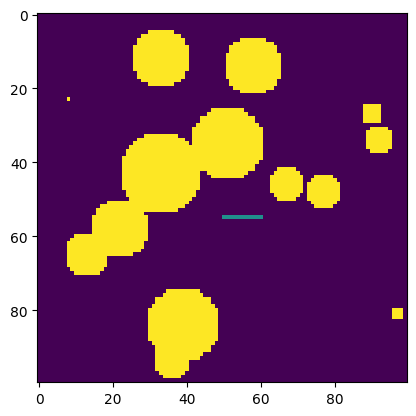

In [16]:
plotting_results(environment, rod, plan_d, save_path='rod_solve_d.mp4')

### B (10 pts) Change the heuristic function now to be h(q,qG) = L1 norm of the x,y components. 
Comment on the changes, how many states have been visited compared to Dijkstra? What is the final cost? Comment on the results.

- the final cost is the same as for dijkstra
- the total number of cycles is les by ~ 50% but each cycle takes longer time to find the node with the lowest (cost+heuristic), so with current implementation it's faster to use dijkstra algorithm.

In [17]:
success, plan_A, count_A, costs_A = Astar('A*')
print(f'reached goal in {len(plan_A)} number of steps after {count_A} cycles')

reached goal in 117 number of steps after 5607 cycles


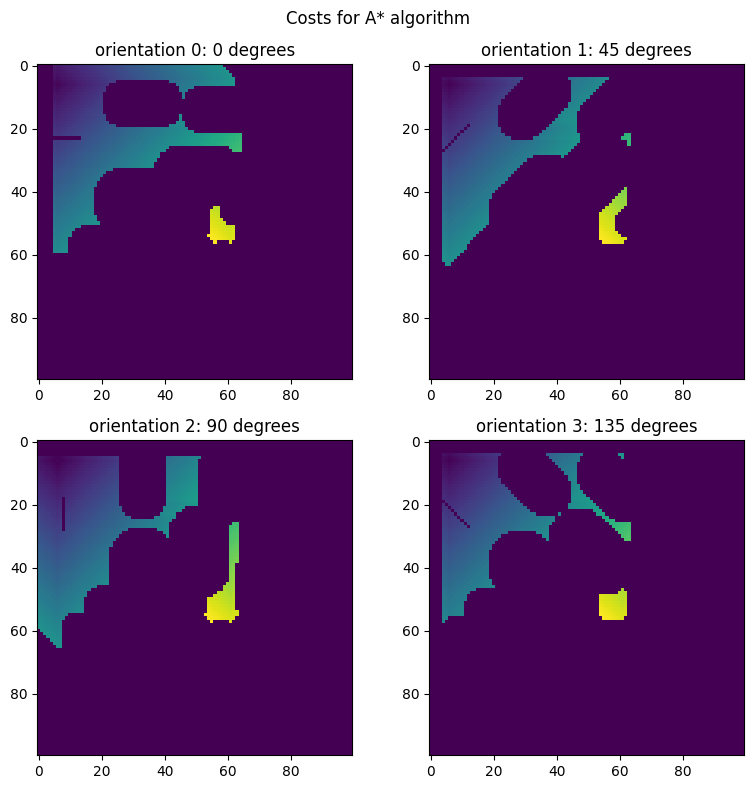

In [18]:
imgs = np.where(costs_A == 10**8, 0, costs_A) # change values for obstacles so they won't affect coloring of the images
plot_for_4_orientations(imgs, suptitle='Costs for A* algorithm')

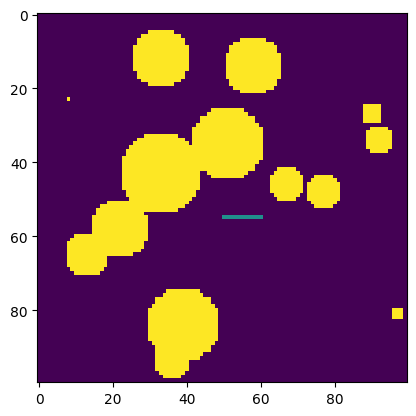

In [19]:
plotting_results(environment, rod, plan_A, save_path='rod_solve_A.mp4')

### C (10 pts) Propose an heuristic function h(q,qG) that includes orientation. Compare metrics with the previous results. Comment on the results

```python
def h_l1_(x,y,z, goal=goal):
  return int(np.abs(x-goal[0])+np.abs(y-goal[1])+np.abs(z-goal[2])%3)
```

I tried to use the same l1 norm as in the previous task but I added difference along z axis too. I used %3 because if 3 rotations are needed (i.e. from orientation 3 to orientation 0) then the same can be done in 1 rotation. In the end, it didn't change anything - nor did it change heuristic values, nor did it change the total number of cycles 

In [20]:
success, plan_A, count_A, costs_A = Astar('A*_')
print(f'reached goal in {len(plan_A)} number of steps after {count_A} cycles')

reached goal in 117 number of steps after 5607 cycles


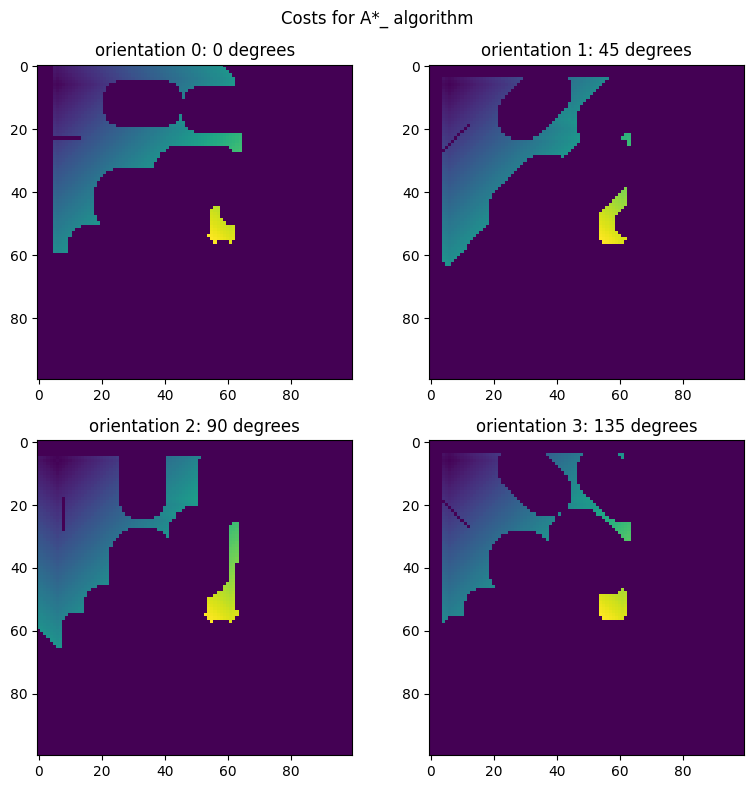

In [21]:
imgs = np.where(costs_A == 10**8, 0, costs_A) # change values for obstacles so they won't affect coloring of the images
plot_for_4_orientations(imgs, suptitle='Costs for A*_ algorithm')